In [24]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
from rdkit.Chem import AllChem
from rdkit.Chem import rdPartialCharges
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

In [25]:
df = pd.read_csv(r'D:\BIBM_project\3B_data\DrugBank_uni_esm2_3B.csv')
df.head()

,0,1,SMILES,Target_sequence,Label,unimol_encoding,target_embedding
0,DB00303,P45059,[H][C@]12[C@@H](C)C(S[C@]3([H])CN[C@@]([H])(C3...,MVKFNSSRKSGKSKKTIRKLTAPETVKQNKPQKVFEKCFMRGRYML...,1,"[-0.2632623314857483, -0.11634709686040878, 0....","[3.937832, -4.5610986, -1.5059096, 4.763294, 3..."
1,DB00114,P19113,CC1=NC=C(COP(O)(O)=O)C(C=O)=C1O,MMEPEEYRERGREMVDYICQYLSTVRERRVTPDVQPGYLRAQLPES...,1,"[-0.5830875039100647, 0.39205265045166016, 1.1...","[5.119278, -7.4051247, 3.8747115, 3.124652, -1..."
2,DB00117,P19113,N[C@@H](CC1=CNC=N1)C(O)=O,MMEPEEYRERGREMVDYICQYLSTVRERRVTPDVQPGYLRAQLPES...,1,"[-0.4533002972602844, 0.5464305877685547, 0.62...","[5.119278, -7.4051247, 3.8747115, 3.124652, -1..."
3,DB00142,Q9UI32,N[C@@H](CCC(O)=O)C(O)=O,MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQ...,1,"[-0.586250364780426, 0.7800034284591675, 0.574...","[3.8181303, -4.1893578, 5.340713, 1.8750579, 4..."
4,DB01839,P00488,CC(O)CO,MSETSRTAFGGRRAVPPNNSNAAEDDLPTVELQGVVPRGVNLQEFL...,1,"[0.13164080679416656, -0.04532823711633682, 0....","[4.22107, -0.49930394, -1.755277, 1.344187, -4..."


In [26]:
! nvidia-smi

Sun Apr 28 11:52:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080      WDDM  |   00000000:01:00.0 Off |                  N/A |
|  0%   37C    P8             10W /  320W |    8334MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [27]:
type(df['target_embedding'][0])

str

In [28]:
def str_to_np_array(str):
    str = str.replace("\n", "")
    str = str.replace("[", "")  # 去除左方括号
    str = str.replace("]", "")  # 去除右方括号
    str_vals = str.split(",")   # 使用逗号来分割字符串
    return np.array(str_vals, dtype=np.float32)



df['target_embedding'] = df['target_embedding'].apply(str_to_np_array)
df['unimol_encoding'] = df['unimol_encoding'].apply(eval)
df = df.dropna()




In [29]:
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU.")
else:
    print("CUDA is not available. GPU is not supported on this system.")


CUDA is available. You can use GPU.


In [30]:
torch.cuda.device_count()

1

In [31]:
df.head()

,0,1,SMILES,Target_sequence,Label,unimol_encoding,target_embedding
0,DB00303,P45059,[H][C@]12[C@@H](C)C(S[C@]3([H])CN[C@@]([H])(C3...,MVKFNSSRKSGKSKKTIRKLTAPETVKQNKPQKVFEKCFMRGRYML...,1,"[-0.2632623314857483, -0.11634709686040878, 0....","[3.937832, -4.5610986, -1.5059096, 4.763294, 3..."
1,DB00114,P19113,CC1=NC=C(COP(O)(O)=O)C(C=O)=C1O,MMEPEEYRERGREMVDYICQYLSTVRERRVTPDVQPGYLRAQLPES...,1,"[-0.5830875039100647, 0.39205265045166016, 1.1...","[5.119278, -7.4051247, 3.8747115, 3.124652, -1..."
2,DB00117,P19113,N[C@@H](CC1=CNC=N1)C(O)=O,MMEPEEYRERGREMVDYICQYLSTVRERRVTPDVQPGYLRAQLPES...,1,"[-0.4533002972602844, 0.5464305877685547, 0.62...","[5.119278, -7.4051247, 3.8747115, 3.124652, -1..."
3,DB00142,Q9UI32,N[C@@H](CCC(O)=O)C(O)=O,MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQ...,1,"[-0.586250364780426, 0.7800034284591675, 0.574...","[3.8181303, -4.1893578, 5.340713, 1.8750579, 4..."
4,DB01839,P00488,CC(O)CO,MSETSRTAFGGRRAVPPNNSNAAEDDLPTVELQGVVPRGVNLQEFL...,1,"[0.13164080679416656, -0.04532823711633682, 0....","[4.22107, -0.49930394, -1.755277, 1.344187, -4..."


In [32]:
train_df = df.sample(frac=0.7, random_state=200)
temp_df = df.drop(train_df.index)
valid_df = temp_df.sample(frac=0.66, random_state=200)
test_df = temp_df.drop(valid_df.index)

In [33]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.head()

,0,1,SMILES,Target_sequence,Label,unimol_encoding,target_embedding
0,DB02103,Q12866,[H][C@@]1(CO)CC[C@@]([H])(O1)N1C=NC2=C1N=C(Cl)...,MGPAPLPLLLGLFLPALWRRAITEAREEAKPYPLFPGPFPGSLQTD...,0,"[-0.40939849615097046, -0.5894134640693665, 0....","[3.5828826, -5.9347024, 0.88416725, 3.0007079,..."
1,DB00675,P71278,CC\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=...,MSAEKLFTPLKVGAVTAPNRVFMAPLTRLRSIEPGDIPTPLMGEYY...,0,"[-0.19765575230121613, -0.27443504333496094, 0...","[1.8634391, -13.034275, 2.6959229, 1.3616855, ..."
2,DB08339,P00747,CN1C(=O)C(=CC2=CN=C(NC3=CC(CO)=CC=C3)N=C12)C1=...,MEHKEVVLLLLLFLKSGQGEPLDDYVNTQGASLFSVTKKQLGAGSI...,0,"[-0.23785123229026794, -0.6222177743911743, 0....","[4.1191025, -10.820947, -5.6943016, 0.69438905..."
3,DB07631,P11797,CCCCCCCCCCCC[N+](C)(C)CC([O-])=O,MSTRKAVIGYYFIPTNQINNYTETDTSVVPFPVSNITPAKAKQLTH...,0,"[-0.11077546328306198, -0.4805830419063568, -0...","[2.1227875, -4.793505, -5.8333445, -4.3458276,..."
4,DB02054,O43681,NC1=CC=CC(=C1)C(O)=O,MAAGVAGWGVEAEEFEDAPDVEPLEPTLSNIIEQRSLKWIFVGGKG...,0,"[-0.40276050567626953, 0.3623400330543518, 0.0...","[5.0765696, -10.657153, 8.738444, 6.264897, -3..."


双线性池化

In [34]:
import torch
import torch.nn as nn

class TransVecNet(nn.Module):
    def __init__(self, target_embed_len=2560, drug_embed_len=512, nhead=4, num_layers=8, dropout=0.5):
        super(TransVecNet, self).__init__()

        self.target_encoder_layer = nn.TransformerEncoderLayer(d_model=target_embed_len, nhead=nhead)
        self.target_transformer_encoder = nn.TransformerEncoder(self.target_encoder_layer, num_layers=num_layers)

        self.drug_encoder_layer = nn.TransformerEncoderLayer(d_model=drug_embed_len, nhead=nhead)
        self.drug_transformer_encoder = nn.TransformerEncoder(self.drug_encoder_layer, num_layers=num_layers)

        self.bilinear_pooling = nn.Bilinear(target_embed_len, drug_embed_len, 1, bias=False)

        self.fc1 = nn.Linear(target_embed_len + drug_embed_len + 1, 2048)  # +1 for the bilinear term
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, target_input, drug_input):
        target_input = target_input.unsqueeze(0)
        drug_input = drug_input.unsqueeze(0)

        x_target = self.target_transformer_encoder(target_input)
        x_drug = self.drug_transformer_encoder(drug_input)

        # Using mean pooling for both target and drug embeddings
        x_target_avg = torch.mean(x_target, dim=0)
        x_drug_avg = torch.mean(x_drug, dim=0)

        bilinear_term = self.bilinear_pooling(x_target_avg, x_drug_avg)
        # Concatenate target, drug embeddings and bilinear term
        x = torch.cat((x_target_avg, x_drug_avg, bilinear_term), dim=1)

        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.fc6(x)
        return x


In [35]:
class MoleculeDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #get the drug embeddings from the column of 0 to 99
        molecule_data = torch.tensor(self.df.loc[idx, 'unimol_encoding'])
        #get the protein embeddings from the df 'Target_embedding' column
        protein_data = torch.tensor(self.df.loc[idx, 'target_embedding']) 
        # get the label column of df
        label = torch.tensor(self.df['Label'].iloc[idx]).view(-1, 1)

        return molecule_data, protein_data, label


In [36]:
# 创建数据加载器
batch_size = 32  # 可以根据具体情况调整批处理大小
train_dataset = MoleculeDataset(train_df)
valid_dataset = MoleculeDataset(valid_df)
test_dataset = MoleculeDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # 这里我们通常不需要对测试集进行shuffle

train_loader



In [37]:

from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, average_precision_score

def metrics(y_true, y_pred, threshold=0.5):
    y_bin = (torch.sigmoid(torch.tensor(y_pred)) > threshold).float().tolist()
    auc_roc = roc_auc_score(y_true, y_pred)  
    acc = accuracy_score(y_true, y_bin) 
    recall = recall_score(y_true, y_bin) 
    aupr = average_precision_score(y_true, y_pred)  
    
    return auc_roc, acc, recall, aupr

def train(model, device, train_loader, criterion, optimizer, epoch, best_val_loss, best_val_auc, model_path):
    model.train()
    train_losses = []
    y_true = []
    y_pred = []
    y_true_bin = [] # for accuracy
    y_pred_bin = [] # for accuracy
    for batch_idx, (molecule_data, protein_data, target) in enumerate(train_loader):
        molecule_data, protein_data, target = molecule_data.float().to(device), protein_data.float().to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(protein_data, molecule_data)
        target = target.squeeze(1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        train_losses.append(train_loss)

        # calculate accuracy
        pred = (torch.sigmoid(output) > 0.5).float()
        
        y_true.extend(target.tolist())
        y_pred.extend(torch.sigmoid(output).tolist()) 

        # add to list for accuracy
        y_true_bin.extend(target.tolist())
        y_pred_bin.extend(pred.squeeze().tolist())

    train_loss_avg = sum(train_losses) / len(train_losses)
    train_auc = roc_auc_score(y_true, y_pred)
    train_acc = accuracy_score(y_true_bin, y_pred_bin)

    print('Train Epoch: {} \tLoss: {:.6f} \tAUC: {:.6f} \tAccuracy: {:.6f}'.format(
        epoch, train_loss_avg, train_auc, train_acc))
    
    val_loss, val_auc, val_acc = validate(model, device, valid_loader, criterion)
    
    # Always save the model with current val_loss and val_auc in filename
    current_model_path = f"{model_path}_loss-{val_loss:.4f}_auc-{val_auc:.4f}.pt"
    torch.save(model.state_dict(), current_model_path)
    print(f'Model saved as {current_model_path}')
    
    # Update best metrics if improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
    if val_auc > best_val_auc:
        best_val_auc = val_auc
    
    return train_loss_avg, train_auc, train_acc, best_val_loss, best_val_auc



def validate(model, device, valid_loader, criterion):
    model.eval()
    validate_loss = 0.0
    y_true = []
    y_pred = []
    y_true_bin = [] 
    y_pred_bin = [] 
    print('start validation')
    with torch.no_grad():
        for idx, (molecule_data, protein_data, target) in enumerate(valid_loader):
            molecule_data, protein_data, target = molecule_data.float().to(device), protein_data.float().to(device), target.float().to(device)
            
            output = model(protein_data, molecule_data)
            target = target.squeeze(1)
            validate_loss += criterion(output, target).item()
            
            pred = (torch.sigmoid(output) > 0.5).float()
            y_true_bin.extend(target.tolist())
            y_pred_bin.extend(pred.squeeze().tolist())
            
            y_true.extend(target.tolist())
            y_pred.extend(torch.sigmoid(output).tolist()) # apply sigmoid to convert output to [0, 1] range

    validate_loss /= len(valid_loader.dataset)
    val_acc = accuracy_score(y_true_bin, y_pred_bin)
    val_auc = roc_auc_score(y_true, y_pred)

    print('\nValidation set: Average loss: {:.6f}, AUC: {:.6f}, Accuracy: {:.6f}\n'.format(
        validate_loss, val_auc, val_acc))
    
    return validate_loss, val_auc, val_acc



def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []

    print('start testing')
    with torch.no_grad():
        for idx, (molecule_data, protein_data, target) in enumerate(test_loader):
            molecule_data, protein_data, target = molecule_data.float().to(device), protein_data.float().to(device), target.float().to(device)
            
            output = model(protein_data, molecule_data)
            target = target.squeeze(1)
            test_loss += criterion(output, target).item()
            
            y_pred.extend(output.tolist())
            
            y_true.extend(target.tolist())

    test_loss /= len(test_loader)  
    test_auc, test_acc, test_recall,  test_aupr = metrics(y_true, y_pred)
    test_auc1 = roc_auc_score(y_true, y_pred)

    print('\nTest set: Average loss: {:.6f}, AUC: {:.6f}, Accuracy: {:.6f}, Recall: {:.6f}, AUPR: {:.6f}\n'.format(
        test_loss, test_auc1, test_acc, test_recall, test_aupr))
    
    return test_loss, test_auc1, test_acc, test_recall, test_aupr

In [42]:
history = {
    'train_loss': [],
    'train_auc': [],
    'train_acc': [],  
    'valid_loss': [],
    'valid_auc': [],
    'valid_acc': [],  
    'test_loss': [],
    'test_auc': [],
    'test_acc': []  
}
device = torch.device('cuda')
model = TransVecNet(target_embed_len=2560, drug_embed_len=512).to(device)
# pos_weight = torch.tensor([0.7 / 0.3])



criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.000005,weight_decay=0.001)

# Define the learning rate scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)


epochs = 20
model_path = 'best_model1.pt'  # Define the path of the saved model
best_val_loss = float('inf')   # 初始化最佳验证损失
best_val_auc = float('-inf')   # 初始化最佳验证 AUC

for epoch in range(1, epochs + 1):
    train_loss_avg, train_auc, train_acc, best_val_loss,best_val_auc = train(model, device, train_loader, criterion, optimizer, epoch, best_val_loss,best_val_auc, model_path)
    valid_loss, valid_auc, valid_acc = validate(model, device, valid_loader, criterion)

    # Append the metrics to the history dict
    history['train_loss'].append(train_loss_avg)
    history['train_auc'].append(train_auc)
    history['train_acc'].append(train_acc)  # Add accuracy to the history
    history['valid_loss'].append(valid_loss)
    history['valid_auc'].append(valid_auc)
    history['valid_acc'].append(valid_acc)  # Add accuracy to the history
    
test_loss, test_auc, test_acc, test_sensitivity, test_aupr = test(model, device, test_loader, criterion)
history['test_loss'].append(test_loss)
history['test_auc'].append(test_auc)


Train Epoch: 1 	Loss: 0.644025 	AUC: 0.657303 	Accuracy: 0.604365
start validation

Validation set: Average loss: 0.018156, AUC: 0.759442, Accuracy: 0.674117

Model saved as best_model1.pt_loss-0.0182_auc-0.7594.pt
start validation

Validation set: Average loss: 0.018159, AUC: 0.759442, Accuracy: 0.674117

Train Epoch: 2 	Loss: 0.575578 	AUC: 0.760469 	Accuracy: 0.684683
start validation

Validation set: Average loss: 0.016853, AUC: 0.804259, Accuracy: 0.721846

Model saved as best_model1.pt_loss-0.0169_auc-0.8043.pt
start validation

Validation set: Average loss: 0.016856, AUC: 0.804259, Accuracy: 0.721846

Train Epoch: 3 	Loss: 0.541586 	AUC: 0.798130 	Accuracy: 0.719274
start validation

Validation set: Average loss: 0.015970, AUC: 0.829712, Accuracy: 0.739726

Model saved as best_model1.pt_loss-0.0160_auc-0.8297.pt
start validation

Validation set: Average loss: 0.015986, AUC: 0.829712, Accuracy: 0.739726

Train Epoch: 4 	Loss: 0.510972 	AUC: 0.825671 	Accuracy: 0.744809
start vali

In [ ]:
model = TransVecNet()  

model_path = 'best_model1.pt'
model.load_state_dict(torch.load(model_path))

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_loss, test_auc, test_acc, test_sensitivity, test_aupr = test(model, device, test_loader, criterion)


start testing

Test set: Average loss: 0.402908, AUC: 0.903673, Accuracy: 0.824188, Recall: 0.809605, AUPR: 0.906028



ValueError: too many values to unpack (expected 3)

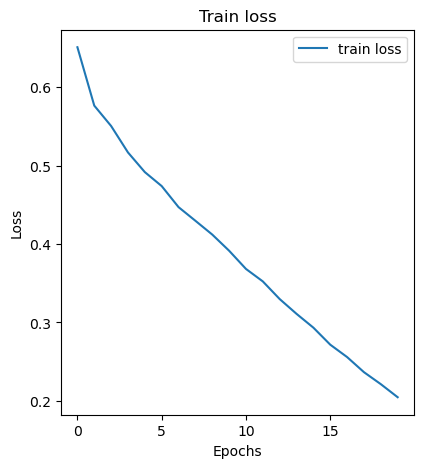

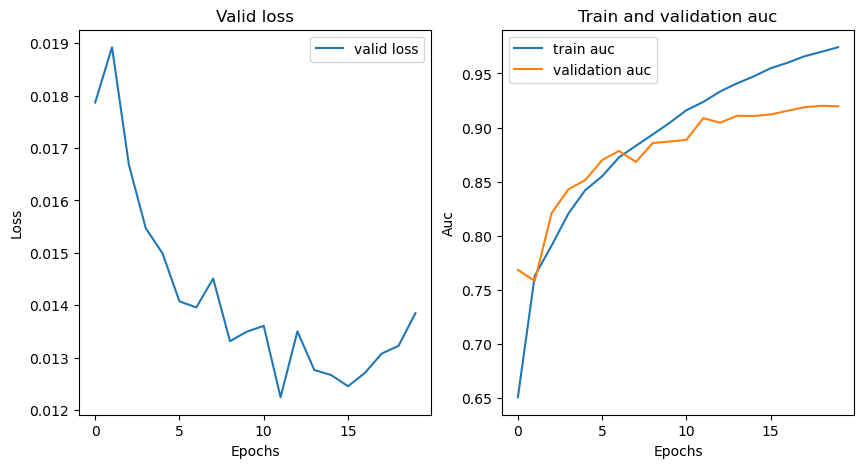

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss')
plt.legend()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['valid_loss'], label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Valid loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history['train_auc'], label='train auc')
plt.plot(history['valid_auc'], label='validation auc')
plt.xlabel('Epochs')
plt.ylabel('Auc')
plt.title('Train and validation auc')
plt.legend()

In [ ]:
# Create a DataFrame from the valid_auc data
df = pd.DataFrame(history['valid_auc'], columns=['valid_auc'])

# Write the DataFrame to a CSV file
df.to_csv('valid_auc(D_unimol_attention（LN)).csv', index=False)



In [ ]:
import pandas as pd
# Create a DataFrame from the valid_auc data
df = pd.DataFrame(history['valid_acc'], columns=['valid_acc'])

# Write the DataFrame to a CSV file
df.to_csv('valid_acc(D_unimol_attention(LN)).csv', index=False)
